In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
from torch.distributions import Categorical
from tqdm import tqdm

sys.path.append('../src')
from ncp import NCP
from nets import MLP
from sim import make_dataset
from utils import map_labels, show_dataset

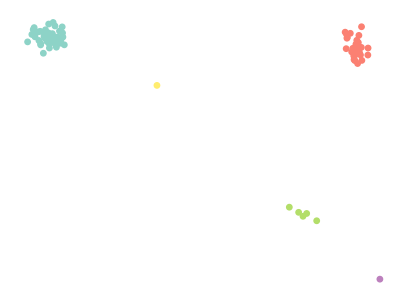

In [61]:
def relable(cs):
    cs, d, k = cs.copy(), {}, 0
    
    for i in range(len(cs)):
        j = cs[i]

        if j not in d:
            d[j] = k
            k += 1
        
        cs[i] = d[j]

    return cs

def generate(alpha=.7, N=None, N_min=5, N_max=100, no_ones=False):
    keep = True

    while keep:
        if N is None or N == 0:
            N = np.random.randint(N_min, N_max)
        clusters = np.zeros(N + 2)
        clusters[0], clusters[1], clusters[2] = 0, 1, alpha
        index_new = 2

        for n in range(N - 1):
            p = clusters/clusters.sum()
            z = np.argmax(np.random.multinomial(1, p))

            if z < index_new:
                clusters[z] += 1
            else:
                clusters[index_new] = 1
                index_new += 1
                clusters[index_new] = alpha

        clusters[index_new] = 0
        clusters = clusters.astype(np.int32)

        if no_ones:
            clusters = clusters[clusters != 1]

        N = int(np.sum(clusters))
        keep = N == 0

    K = np.sum(clusters > 0)

    return clusters, N, K

class Data:
    def __init__(self, x_dim=2, lamb=10, sigma=1, alpha=.7, N_min=5, N_max=100):
        self.x_dim = x_dim
        self.lamb = lamb
        self.sigma = sigma
        self.alpha = alpha
        self.N_min = N_min
        self.N_max = N_max

    def generate(self, N=None, batch_size=64, return_tensor=False):
        clusters, N, n_clusters = generate(self.alpha, N, self.N_min, self.N_max)
        cumsum = np.cumsum(clusters)
        data = np.empty((batch_size, N, self.x_dim))
        cs = np.empty(N, dtype=np.int32)

        for i in range(n_clusters):
            mu = np.random.normal(0, self.lamb, size=(self.x_dim*batch_size, 1))
            samples = np.random.normal(mu, self.sigma, size=(self.x_dim*batch_size, clusters[i + 1]))
            samples = np.swapaxes(samples.reshape((batch_size, self.x_dim, clusters[i + 1])), 1, 2)
            data[:, cumsum[i]:cumsum[i + 1], :] = samples
            cs[cumsum[i]:cumsum[i + 1]] = i + 1

        arr = np.arange(N)
        np.random.shuffle(arr)
        cs = cs[arr]
        data = data[:, arr, :]
        cs = relable(cs)
        medians = np.expand_dims(np.median(data, axis=1), 1)
        data = data - medians

        if return_tensor:
            return torch.tensor(data, dtype=torch.float32), torch.tensor(cs)

        # return data, cs, clusters, n_clusters
        return data, cs
    
generator = Data(x_dim=2)
data, labels = generator.generate()
show_dataset(data[0], labels)

NCP: 100%|██████████| 200/200 [02:16<00:00,  1.46it/s]


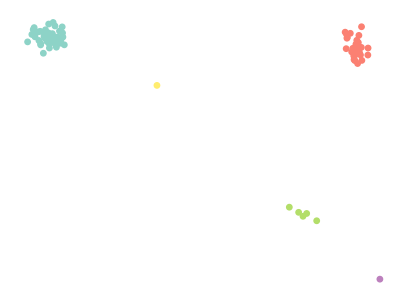

In [62]:
WC_CHANNELS = (128, 128, 128, 128, 256)
BC_CHANNELS = (WC_CHANNELS[-1], 128, 128, 128, 128, 128, 512)
LP_CHANNELS = (WC_CHANNELS[-1] + BC_CHANNELS[-1], 128, 128, 128, 128)

model = NCP(WC_CHANNELS, BC_CHANNELS, LP_CHANNELS).fit(Data(2, N_max=25))
show_dataset(data[0], model(torch.tensor(data, dtype=torch.float32)))